In [1]:
from cleanlab.filter_copy import find_label_issues_bench, find_label_issues_cow, find_label_issues_naive, find_label_issues_numba, find_label_issues_cow_spawn, find_label_issues_thread

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)

In [3]:
def normalize(arr): 
    normalized = np.zeros(arr.shape, dtype=np.float16) 
    for i, a in enumerate(arr): 
        normalized[i] = a / np.sum(a) 
    return normalized 

In [4]:
colormap = plt.cm.rainbow

In [5]:
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)]
#n_m = [(50, 1000)]

In [6]:
nt = 9
ncores = 10

In [7]:
#runtimes = np.zeros((len(n_m), ncores, nt))
#runtimes_cow = np.zeros((len(n_m), ncores, nt))
#runtimes_naive = np.zeros((len(n_m), ncores, nt))
#runtimes_numba = np.zeros((len(n_m), ncores, nt))
runtimes_spawn = np.zeros((len(n_m), ncores, nt))
runtimes_thread = np.zeros((len(n_m), ncores, nt))

In [8]:
np.random.seed(0) 

In [9]:
import multiprocessing
# for testing spawn on linux
multiprocessing.set_start_method('fork')

# careful benchmarking

In [10]:
# we need to do a dummy computation to compile numba code
n = 100
m = 5
pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
pred_probs = normalize(pred_probs) 
labels = np.repeat(np.arange(m), n // m) 
_, _ = find_label_issues_numba(pred_probs=pred_probs, labels=labels, n_jobs=1)

In [17]:
for i, nm in enumerate(n_m): # varying number of classes 
    print(f"starting pair {nm}")
    n = nm[1]
    m = nm[0]
    pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
    pred_probs = normalize(pred_probs) 
    labels = np.repeat(np.arange(m), n // m) 
    for n_jobs in range(ncores): 
        print(f"n_jobs {n_jobs+1}")
        # original implementation
        #issues, times = find_label_issues_bench(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes[i, n_jobs, :] = times
        
        # spawn
        issues_spawn, times_spawn = find_label_issues_cow_spawn(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes_spawn[i, n_jobs, :] = times_spawn
        
        # thread
        issues_thread, times_thread = find_label_issues_thread(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes_thread[i, n_jobs, :] = times_thread
        
        # naive implementation with fork
        #issues_naive, times_naive = find_label_issues_naive(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes_naive[i, n_jobs, :] = times_naive
        
        # numba
        #issues_numba, times_numba = find_label_issues_numba(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes_numba[i, n_jobs, :] = times_numba
        
        # check everyone got the same answer
        #diff1 = np.sum(issues ^ issues_cow)
        #if diff1 != 0:
        #    print(f"original and cow don't match on {diff1}")
        #diff2 = np.sum(issues_cow ^ issues_naive)
        #if diff2 != 0:
        #    print(f"cow and naive don't match on {diff2}")
        #diff3 = np.sum(issues_naive ^ issues_numba)
        #if diff3 != 0:
        #    print(f"numba and naive don't match on {diff3}")
        #diff4 = np.sum(issues ^ issues_numba)
        #if diff4 != 0:
        #    print(f"original and numba don't match on {diff4}")
    print(f"finished pair {nm}") 

#np.save("vary_nm_original.npy", runtimes)
np.save("vary_nm_spawn.npy", runtimes_spawn)
np.save("vary_nm_thread.npy", runtimes_thread)
#np.save("vary_nm_naive.npy", runtimes_naive)
#np.save("vary_nm_numba.npy", runtimes_numba)

starting pair (5000, 20000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 20000)
starting pair (5000, 40000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 40000)
starting pair (5000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 60000)
starting pair (10000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (10000, 60000)
starting pair (15000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (15000, 60000)


In [14]:
runtimes_numba = np.load("vary_nm_numba.npy")

In [18]:
runtime_totals = np.cumsum(runtimes_spawn, axis=-1)

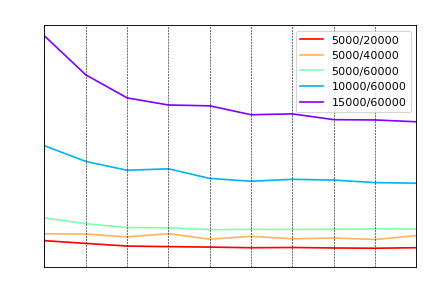

In [19]:
colormap = plt.cm.rainbow 
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

plt.figure(figsize=(6, 4), dpi=80) 
for i, runtime in enumerate(runtime_totals[..., -1]): 
    plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
for x in range(10): 
    plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
plt.legend() 
plt.xticks(np.arange(10)+1) 
plt.xlim([1, 10]) 
plt.xlabel('n_jobs', c='w') 
plt.ylabel('Time (sec)', c='w') 
plt.ylim(bottom=0) 
plt.title('total times with varying m/n', c='w') 
plt.tick_params(colors='w')
plt.show() 

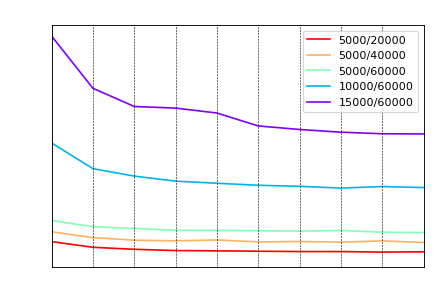

In [13]:
colormap = plt.cm.rainbow 
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

plt.figure(figsize=(6, 4), dpi=80) 
for i, runtime in enumerate(runtime_totals[..., -1]): 
    plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
for x in range(10): 
    plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
plt.legend() 
plt.xticks(np.arange(10)+1) 
plt.xlim([1, 10]) 
plt.xlabel('n_jobs', c='w') 
plt.ylabel('Time (sec)', c='w') 
plt.ylim(bottom=0) 
plt.title('total times with varying m/n', c='w') 
plt.tick_params(colors='w')
plt.show() 

In [12]:
ckpt_names = ['initial checks', 'calc confident joint', 'preproc for prune', 'load to RawArray for multiproc', 'prune by class', 'prune by count', 'confident learning', 'pred neq', 'final processing']

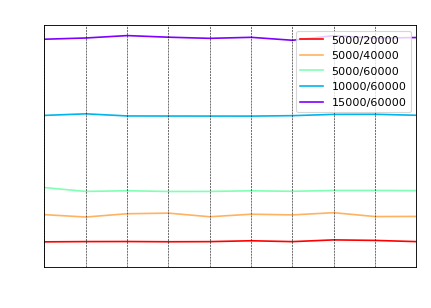

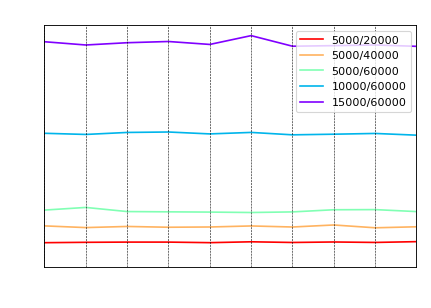

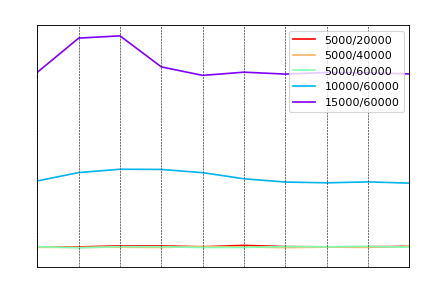

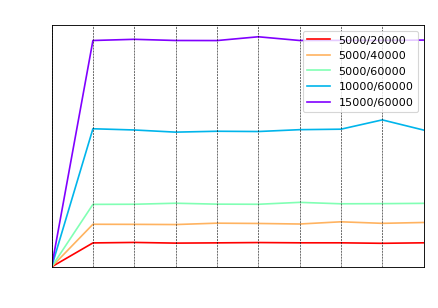

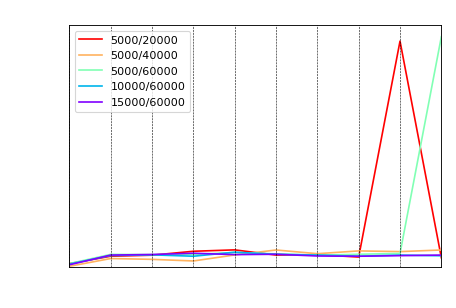

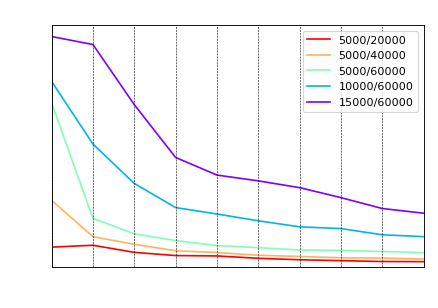

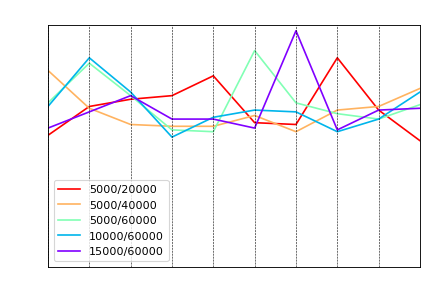

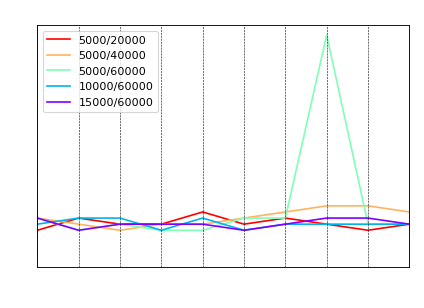

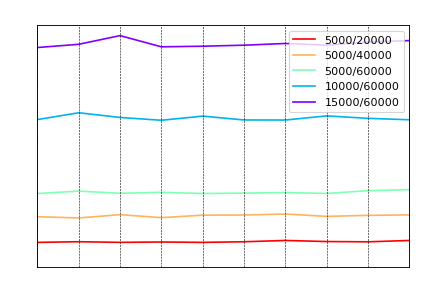

In [34]:
for check_pt in range(nt):
    colormap = plt.cm.rainbow 
    n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
    colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

    plt.figure(figsize=(6, 4), dpi=80) 
    for i, runtime in enumerate(runtimes[..., check_pt]): 
        plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    plt.legend() 
    plt.xticks(np.arange(10)+1) 
    plt.xlim([1, 10]) 
    plt.xlabel('n_jobs', c='w') 
    plt.ylabel('Time (sec)', c='w') 
    plt.ylim(bottom=0) 
    plt.title(f'{ckpt_names[check_pt]} with varying m/n', c='w') 
    plt.tick_params(colors='w')
    plt.show() 

# realistic benchmarks

In [10]:
datasets = [
    ('mnist_test_set', 'image'),
    ('cifar10_test_set', 'image'),
    ('cifar100_test_set', 'image'),
    ('caltech256', 'image'),
    #('imagenet_val_set', 'image'),
    ('20news_test_set', 'text'),
    #('imdb_test_set', 'text'),
    #('amazon', 'text'),
    #('audioset_eval_set', 'audio'),
]

In [11]:
real_labels = []
real_pred_probs = []

for (dataset, modality) in datasets:
    title = 'Dataset: ' + dataset.capitalize()
    print('='*len(title), title, '='*len(title), sep='\n')
    
    # Get the cross-validated predicted probabilities on the test set.
    if dataset == 'amazon' or dataset == 'imagenet_val_set':
        n_parts = 3 if dataset == 'amazon' else 4
        pred_probs_fn = '../label-errors/cross_validated_predicted_probabilities/' \
             '{}_pyx.part{}_of_{}.npy'
        parts = [np.load(pred_probs_fn.format(dataset, i + 1, n_parts)) for i in range(n_parts)]
        pred_probs = np.vstack(parts)
        real_pred_probs.append(pred_probs)
    else:
        pred_probs = np.load('../label-errors/cross_validated_predicted_probabilities/' \
            '{}_pyx.npy'.format(dataset), allow_pickle=True)
        real_pred_probs.append(pred_probs)
    # Get the test set labels
    labels = np.load('../label-errors/original_test_labels/'
        '{}_original_labels.npy'.format(dataset), allow_pickle=True)
    real_labels.append(labels)


Dataset: Mnist_test_set
Dataset: Cifar10_test_set
Dataset: Cifar100_test_set
Dataset: Caltech256
Dataset: 20news_test_set


In [12]:
#runtimes_spawn = np.zeros((len(real_labels), ncores, nt))
#runtimes_thread = np.zeros((len(real_labels), ncores, nt))
runtimes = np.zeros((len(real_labels), ncores, nt))
runtimes_cow = np.zeros((len(real_labels), ncores, nt))
runtimes_naive = np.zeros((len(real_labels), ncores, nt))
runtimes_numba = np.zeros((len(real_labels), ncores, nt))

In [14]:
for i, pred_probs in enumerate(real_pred_probs): # varying number of classes 
    print(f"starting dataset {datasets[i][0]}")
    labels = real_labels[i]
    for n_jobs in range(ncores): 
        print(f"n_jobs {n_jobs+1}")
        # original implementation
        issues, times = find_label_issues_bench(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes[i, n_jobs, :] = times
        
        # cow
        issues_cow, times_cow = find_label_issues_cow(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes_cow[i, n_jobs, :] = times_cow

        # spawn
        #issues_spawn, times_spawn = find_label_issues_cow_spawn(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes_spawn[i, n_jobs, :] = times_spawn
        
        # thread
        #issues_thread, times_thread = find_label_issues_thread(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        #runtimes_thread[i, n_jobs, :] = times_thread
        
        # naive implementation with fork
        issues_naive, times_naive = find_label_issues_naive(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes_naive[i, n_jobs, :] = times_naive
        
        # numba
        issues_numba, times_numba = find_label_issues_numba(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes_numba[i, n_jobs, :] = times_numba
        
        # check everyone got the same answer
        #diff1 = np.sum(issues ^ issues_cow)
        #if diff1 != 0:
        #    print(f"original and cow don't match on {diff1}")
        #diff2 = np.sum(issues_cow ^ issues_naive)
        #if diff2 != 0:
        #    print(f"cow and naive don't match on {diff2}")
        #diff3 = np.sum(issues_naive ^ issues_numba)
        #if diff3 != 0:
        #    print(f"numba and naive don't match on {diff3}")
        #diff4 = np.sum(issues ^ issues_numba)
        #if diff4 != 0:
        #    print(f"original and numba don't match on {diff4}")
    print(f"finished data {datasets[i][0]}") 

#np.save("real_data_spawn.npy", runtimes_spawn)
#np.save("real_data_thread.npy", runtimes_thread)
np.save("real_data_original.npy", runtimes)
np.save("real_data_cow.npy", runtimes_cow)
np.save("real_data_naive.npy", runtimes_naive)
np.save("real_data_numba.npy", runtimes_numba)

starting dataset mnist_test_set
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished data mnist_test_set
starting dataset cifar10_test_set
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished data cifar10_test_set
starting dataset cifar100_test_set
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished data cifar100_test_set
starting dataset caltech256
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished data caltech256
starting dataset 20news_test_set
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished data 20news_test_set


In [27]:
a = np.arange(100).reshape(10,10)

In [28]:
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [29]:
b = 9 - np.arange(10, dtype=int)

In [30]:
c = a[np.arange(10), b]

In [31]:
c

array([ 9, 18, 27, 36, 45, 54, 63, 72, 81, 90])

# benchmarking cow

## debugging cow

I've debugged cow and it seems to be working for prune by count

In [13]:
# cow seems to give different outputs than eveyone else
n = 20
m = 5
pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
pred_probs = normalize(pred_probs) 
labels = np.repeat(np.arange(m), n // m) 

In [14]:
issues, _ = find_label_issues_bench(pred_probs=pred_probs, labels=labels, n_jobs=1) 

# cow
issues_cow, _ = find_label_issues_cow_spawn(pred_probs=pred_probs, labels=labels, n_jobs=1) 

# naive implementation with fork
issues_thread, _ = find_label_issues_thread(pred_probs=pred_probs, labels=labels, n_jobs=1) 

# numba
#issues_numba, _ = find_label_issues_numba(pred_probs=pred_probs, labels=labels, n_jobs=1) 

In [15]:
issues

array([False, False, False, False, False,  True, False,  True, False,
        True,  True,  True, False, False,  True,  True, False,  True,
        True,  True])

In [18]:
issues_cow

array([False, False, False, False, False,  True, False,  True, False,
        True,  True,  True, False, False,  True,  True, False,  True,
        True,  True])

In [19]:
issues_thread

array([False, False, False, False, False,  True, False,  True, False,
        True,  True,  True, False, False,  True,  True, False,  True,
        True,  True])

## cow plots

In [11]:
np.random.seed(0) 
for i, nm in enumerate(n_m): # varying number of classes 
    print(f"starting pair {nm}")
    n = nm[1]
    m = nm[0]
    pred_probs = np.random.randint(low=1, high=100, size=[n, m], dtype=np.uint8) 
    pred_probs = normalize(pred_probs) 
    labels = np.repeat(np.arange(m), n // m) 
    for n_jobs in range(ncores): 
        print(f"n_jobs {n_jobs+1}")
        _, times = find_label_issues_cow(pred_probs=pred_probs, labels=labels, n_jobs=n_jobs+1) 
        runtimes[i, n_jobs, :] = times
    print(f"finished pair {nm}") 
    
np.save('cow_varying_nm.npy', runtimes) 

starting pair (5000, 20000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 20000)
starting pair (5000, 40000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 40000)
starting pair (5000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (5000, 60000)
starting pair (10000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (10000, 60000)
starting pair (15000, 60000)
n_jobs 1
n_jobs 2
n_jobs 3
n_jobs 4
n_jobs 5
n_jobs 6
n_jobs 7
n_jobs 8
n_jobs 9
n_jobs 10
finished pair (15000, 60000)


In [13]:
runtime_totals = np.cumsum(runtimes, axis=-1)

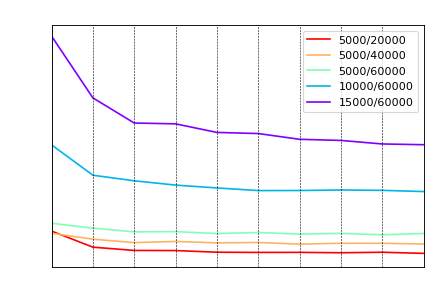

In [14]:
colormap = plt.cm.rainbow 
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

plt.figure(figsize=(6, 4), dpi=80) 
for i, runtime in enumerate(runtime_totals[..., -1]): 
    plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
for x in range(10): 
    plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
plt.legend() 
plt.xticks(np.arange(10)+1) 
plt.xlim([1, 10]) 
plt.xlabel('n_jobs', c='w') 
plt.ylabel('Time (sec)', c='w') 
plt.ylim(bottom=0) 
plt.title('total times with varying m/n', c='w') 
plt.tick_params(colors='w')
plt.show() 

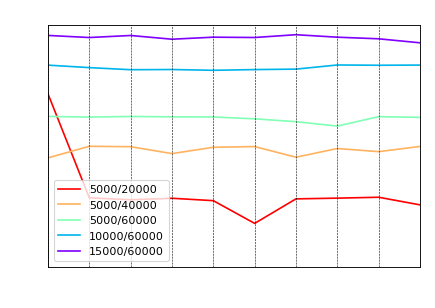

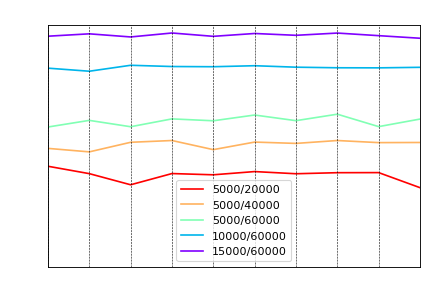

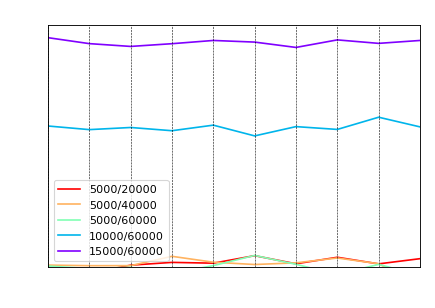

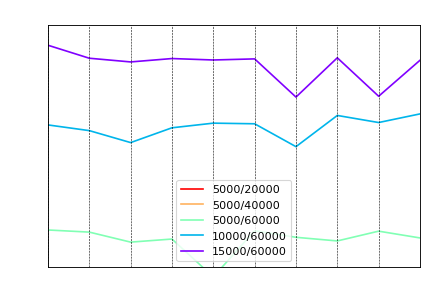

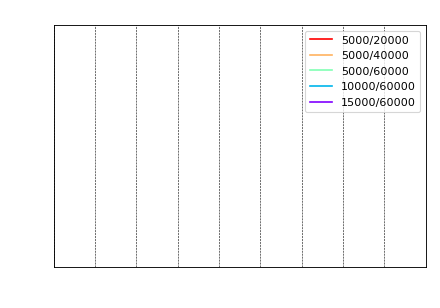

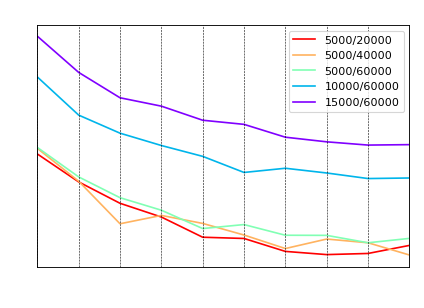

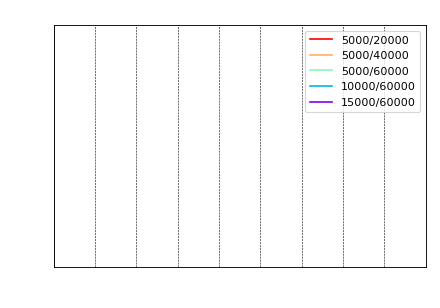

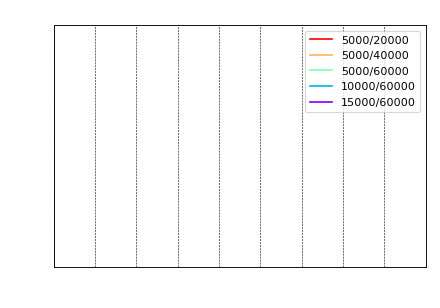

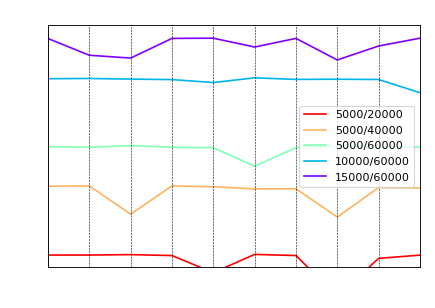

In [16]:
for check_pt in range(nt):
    colormap = plt.cm.rainbow 
    n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
    colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

    plt.figure(figsize=(6, 4), dpi=80) 
    for i, runtime in enumerate(runtimes[..., check_pt]): 
        plt.plot(np.arange(10)+1, np.log(runtime), label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    plt.legend() 
    plt.xticks(np.arange(10)+1) 
    plt.xlim([1, 10]) 
    plt.xlabel('n_jobs', c='w') 
    plt.ylabel('Time (sec)', c='w') 
    plt.ylim(bottom=0) 
    plt.title(f'{ckpt_names[check_pt]} with varying m/n', c='w') 
    plt.tick_params(colors='w')
    plt.show() 

# generate plots

In [20]:
ckpt_names = ['initial checks', 'calc confident joint', 'preproc for prune', 'load to RawArray for multiproc', 'prune by class', 'prune by count', 'confident learning', 'pred neq', 'final processing']

In [22]:
runtimes_orig = np.load("vary_nm_original.npy")
runtimes_naive = np.load("vary_nm_naive.npy")
runtimes_numba = np.load("vary_nm_numba.npy")
runtimes_cow = np.load("vary_nm_cow.npy")
runtimes_spawn = np.load("vary_nm_spawn.npy")
runtimes_thread = np.load("vary_nm_thread.npy")

In [23]:
run_total_orig = np.cumsum(runtimes_orig, axis=-1)
run_total_naive = np.cumsum(runtimes_naive, axis=-1)
run_total_numba = np.cumsum(runtimes_numba, axis=-1)
run_total_cow = np.cumsum(runtimes_cow, axis=-1)
run_total_spawn = np.cumsum(runtimes_spawn, axis=-1)
run_total_thread = np.cumsum(runtimes_thread, axis=-1)

In [24]:
all_runtimes = [runtimes_orig, runtimes_naive, runtimes_cow, runtimes_numba, runtimes_spawn, runtimes_thread]
all_run_totals = [run_total_orig, run_total_naive, run_total_cow, run_total_numba, run_total_spawn, run_total_thread]

In [25]:
run_names = ['baseline', 'naive', 'cow', 'numba', 'spawn', 'thread']
n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 

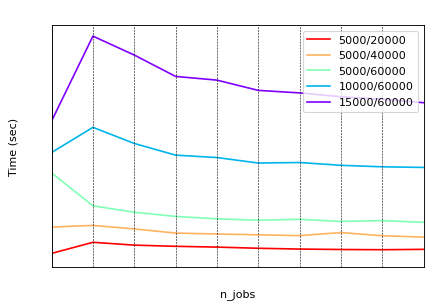

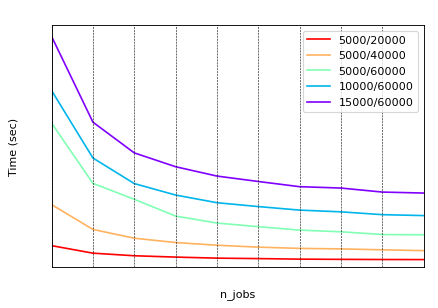

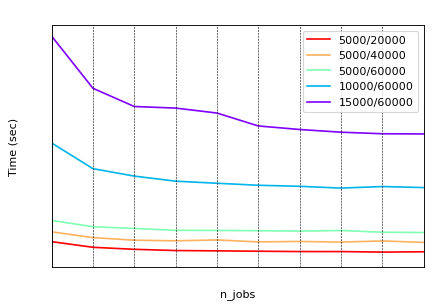

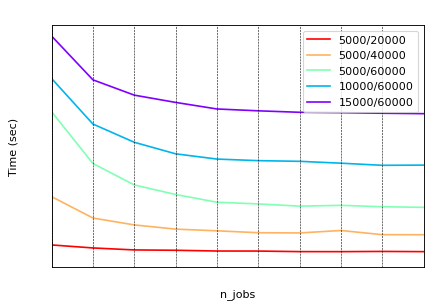

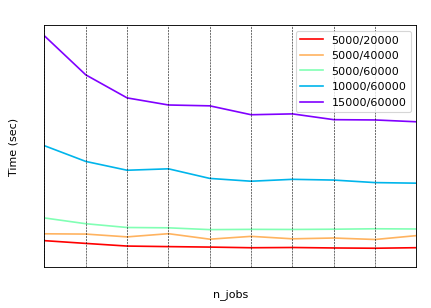

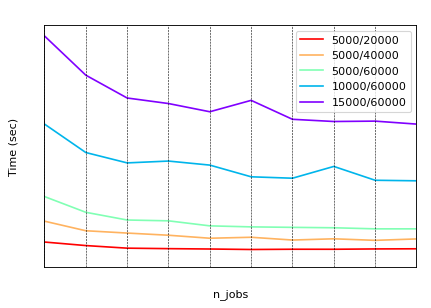

In [27]:
colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

for rn, runtimes in enumerate(all_run_totals):
    plt.figure(figsize=(6, 4), dpi=80) 
    for i, runtime in enumerate(runtimes[..., -1]): 
        plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    plt.legend() 
    plt.xticks(np.arange(10)+1) 
    plt.xlim([1, 10]) 
    plt.xlabel('n_jobs') 
    plt.ylabel('Time (sec)') 
    plt.ylim(bottom=0) 
    plt.title(f'{run_names[rn]}, total times with varying K/n', c='w') 
    plt.tick_params(colors='w')
    plt.show() 

/state/partition1/slurm_tmp/20973585.0.0/ipykernel_25357/3273206857.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


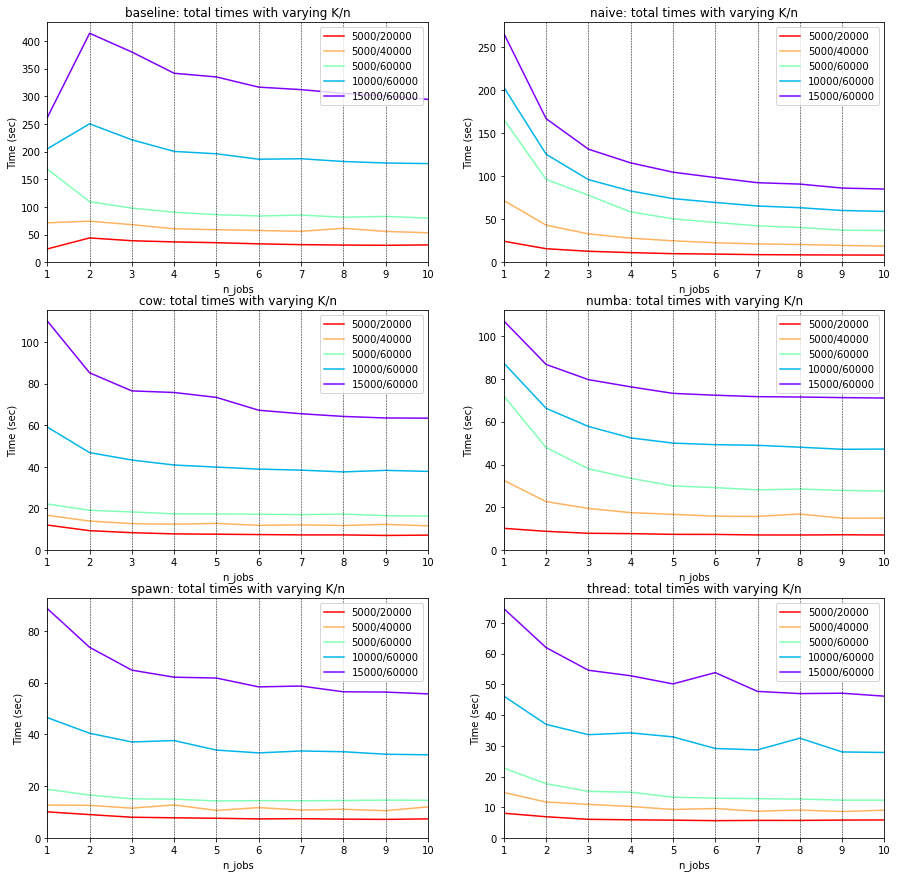

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax_ind = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]
for rn, runtimes in enumerate(all_run_totals):
    for i, runtime in enumerate(runtimes[..., -1]): 
        ax[ax_ind[rn]].plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        ax[ax_ind[rn]].axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    ax[ax_ind[rn]].legend() 
    ax[ax_ind[rn]].set_xticks(np.arange(10)+1) 
    ax[ax_ind[rn]].set_xlim([1, 10]) 
    ax[ax_ind[rn]].set_xlabel('n_jobs') 
    ax[ax_ind[rn]].set_ylabel('Time (sec)') 
    ax[ax_ind[rn]].set_ylim(bottom=0) 
    ax[ax_ind[rn]].set_title(f'{run_names[rn]}: total times with varying K/n') 
    #ax[ax_ind[rn]].set_tick_params(colors='w')
fig.show()
#fig.savefig("total_runtimes.png")

/state/partition1/slurm_tmp/20973585.0.0/ipykernel_25357/3108638194.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


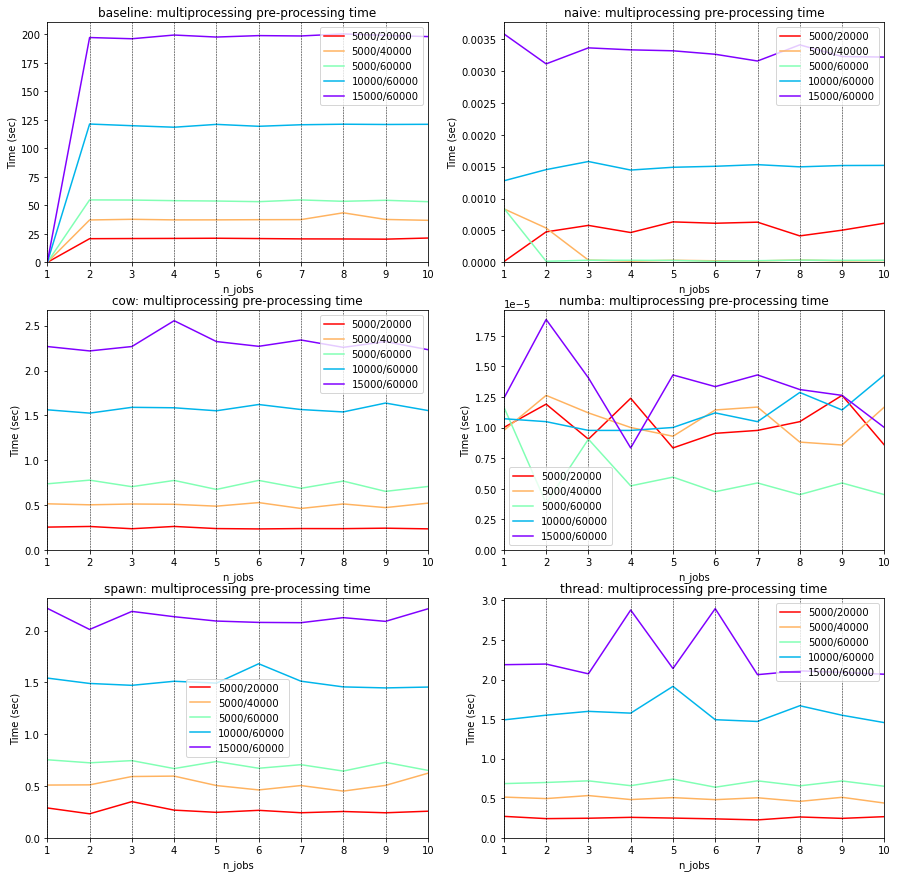

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax_ind = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]
for rn, runtimes in enumerate(all_runtimes):
    for i, runtime in enumerate(runtimes[..., 3]): 
        ax[ax_ind[rn]].plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        ax[ax_ind[rn]].axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    ax[ax_ind[rn]].legend() 
    ax[ax_ind[rn]].set_xticks(np.arange(10)+1) 
    ax[ax_ind[rn]].set_xlim([1, 10]) 
    ax[ax_ind[rn]].set_xlabel('n_jobs') 
    ax[ax_ind[rn]].set_ylabel('Time (sec)') 
    ax[ax_ind[rn]].set_ylim(bottom=0) 
    ax[ax_ind[rn]].set_title(f'{run_names[rn]}: multiprocessing pre-processing time') 
    #ax[ax_ind[rn]].set_tick_params(colors='w')
fig.show()
#fig.savefig("preprocessing.png")

/state/partition1/slurm_tmp/20973585.0.0/ipykernel_25357/778043574.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


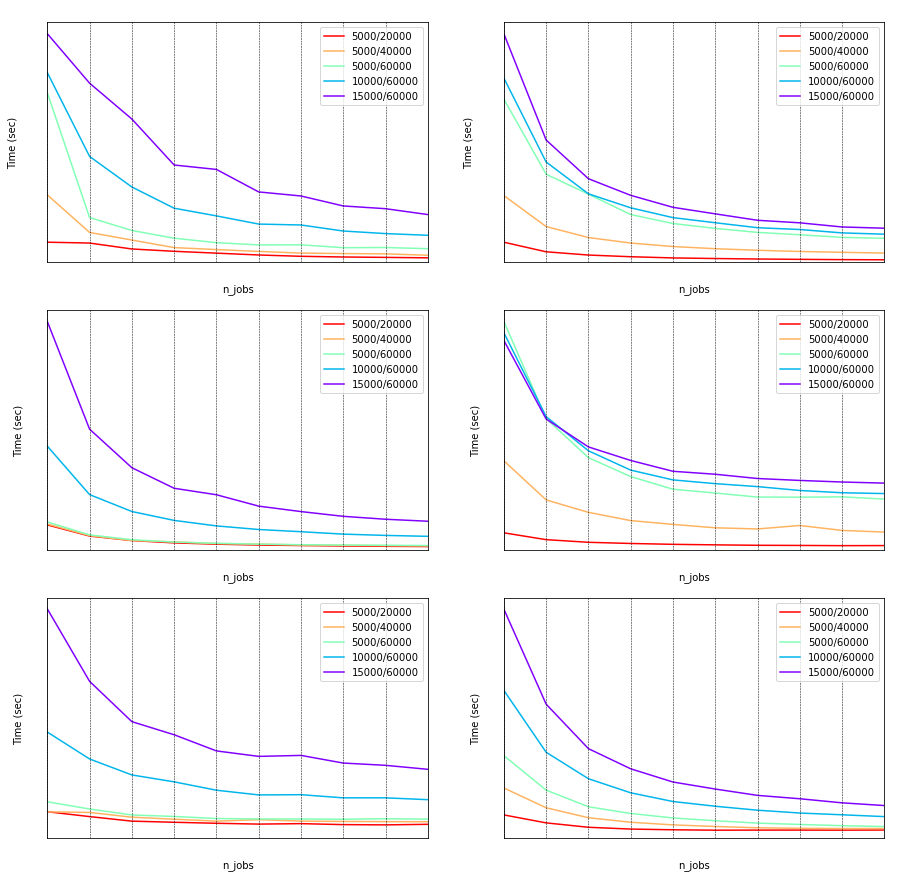

In [35]:
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
ax_ind = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]
for rn, runtimes in enumerate(all_runtimes):
    for i, runtime in enumerate(runtimes[..., 5]): 
        ax[ax_ind[rn]].plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        ax[ax_ind[rn]].axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    ax[ax_ind[rn]].legend() 
    ax[ax_ind[rn]].set_xticks(np.arange(10)+1) 
    ax[ax_ind[rn]].set_xlim([1, 10]) 
    ax[ax_ind[rn]].set_xlabel('n_jobs') 
    ax[ax_ind[rn]].set_ylabel('Time (sec)') 
    ax[ax_ind[rn]].set_ylim(bottom=0) 
    ax[ax_ind[rn]].set_title(f'{run_names[rn]}: multiprocessing run time', c='w') 
    ax[ax_ind[rn]].tick_params(colors='w')
fig.show()
#fig.savefig("multiprocessing.png")

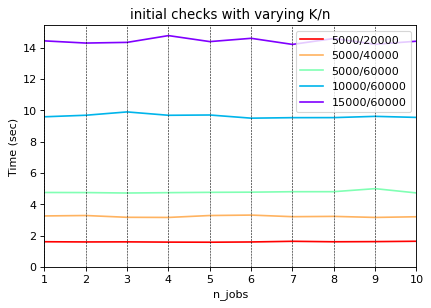

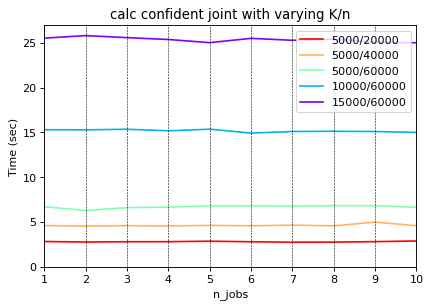

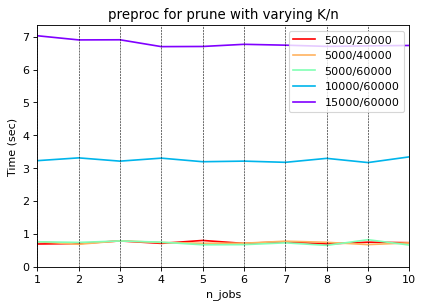

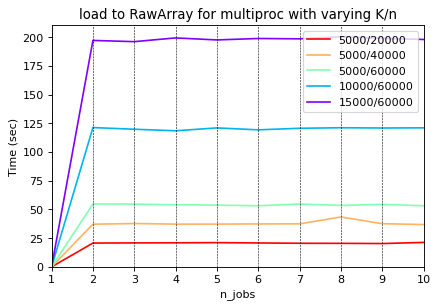

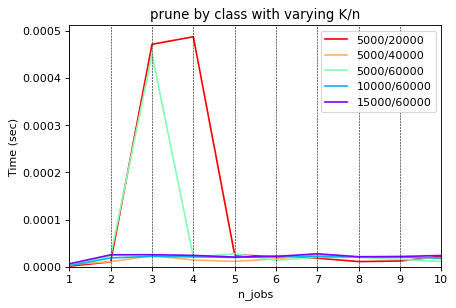

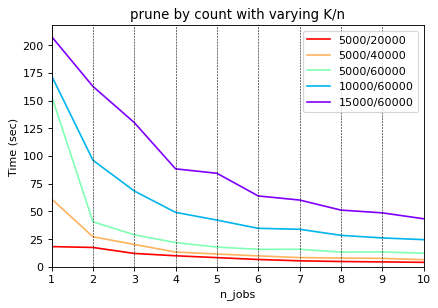

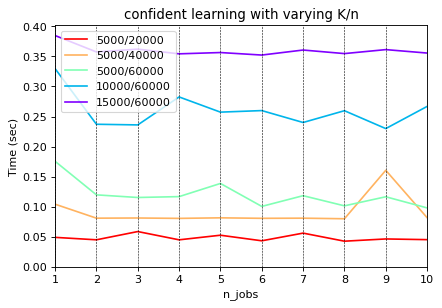

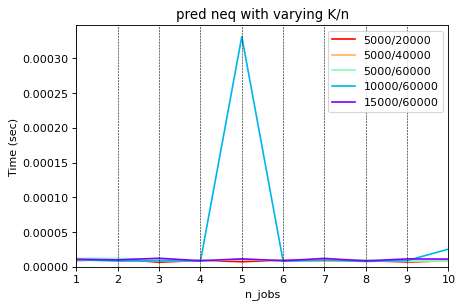

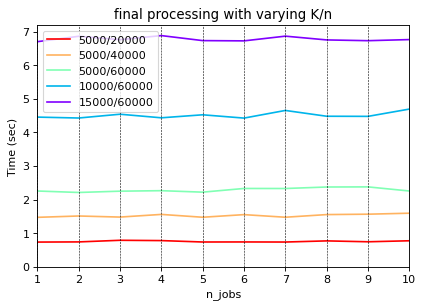

In [20]:
for check_pt in range(nt):
    colormap = plt.cm.rainbow 
    n_m = [(5000, 20000), (5000, 40000), (5000, 60000), (10000, 60000), (15000, 60000)] 
    colors = [colormap(i) for i in np.linspace(1, 0, len(n_m))] 

    plt.figure(figsize=(6, 4), dpi=80) 
    for i, runtime in enumerate(runtimes_orig[..., check_pt]): 
        plt.plot(np.arange(10)+1, runtime, label='%d/%d' % n_m[i], color=colors[i]) 
    for x in range(10): 
        plt.axvline(x=x+1, color='k', linestyle='--', linewidth=0.5) 
    plt.legend() 
    plt.xticks(np.arange(10)+1) 
    plt.xlim([1, 10]) 
    plt.xlabel('n_jobs') 
    plt.ylabel('Time (sec)') 
    plt.ylim(bottom=0) 
    plt.title(f'{ckpt_names[check_pt]} with varying K/n') 
    #plt.tick_params(colors='w')
    plt.show() 